<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/notebooks/2023_1027Knd_Ijn_Ask_s2p_p2s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config InlineBackend.figure_format = 'retina'

* date: 2023_1027
* author: 浅川伸一
* filename: 2023_1027Knd_Ijn_Ask_s2p_p2s.ipynb

# 符号化器‐復号化器 (encoder-decoder a.k.a seq2seq) モデルによる，単語復唱，単語産出，および単語理解処理過程の実装


<center>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4c.svg"><br/>
<img src="https://raw.githubusercontent.com/ShinAsakawa/ShinAsakawa.github.io/master/assets/2004Harm_Seidenberg_fig4d.svg"><br/> -->
<img src="2004Harm_Seidenberg_fig4ab.svg"><br/>
<!--<img src="2004Harm_Seidenberg_fig4c.svg">
<img src="2004Harm_Seidenberg_fig4d.svg"><br/>-->
`2004Harm&Seidenberg2004`, Figure 4 c, and d
</center>

<center>
<img src="2015Loung_fig1.svg" width="24%"><br/>
ニューラル翻訳モデル。
青色がソース言語モデル，赤がターゲット言語モデルである。
ソース言語モデルの，最終時刻の中間層状態を，ターゲット言語モデルの開始時の中間層状態として用いる。
Loung+2015 Fig.1 より。    
</center>


* 文献
    * Harm & Seidenberg (2004) Computing the Meanings of Words in Reading: Cooperative Division of Labor Between Visual and Phonological Processes, Psychological Review, DOI:10.1037/0033-295X.111.3.662
    * Seq2seq 翻訳モデル: Sutskever+ (2014) Sequence to Sequence Learning with Neural Networks, [arXiv:1409.3215](https://arxiv.org/abs/1409.3215)
    * 注意つき符号化器‐復号化器モデル: Bahdanau, Cho, & Bengio (2015) NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE, [arXiv:1409.0473](https://arxiv.org/abs/1409.0473)
    * もう一つの注意つき符号化器‐復号化器モデル Luong+ (2015) Effective Approaches to Attention-based Neural Machine Translation, [arXiv:1508.04025](https://arxiv.org/abs/1508.04025)


# 0 準備
## 0.1 Colab 用 MeCab コンパイル&インストール等

In [2]:
%%time
%config InlineBackend.figure_format = 'retina'
# このセルの実行には 15 分程度かかります。
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

import sys
import os
import numpy as np
from tqdm.notebook import tqdm
import time
import datetime
import matplotlib.pyplot as plt

# ローカルと colab との相違を吸収するために必要となるライブラリをインストール
try:
    import jaconv
except ImportError:
    !pip install jaconv

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

if isColab:
    !pip install --upgrade termcolor==1.1
from termcolor import colored

# MeCab, fugashi, ipadic のインストール
if isColab:
    !apt install aptitude swig > /dev/null 2>&1
    !aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y > /dev/null 2>&1
    !pip install mecab-python3==0.7 > /dev/null 2>&1
    !pip install --upgrade ipadic > /dev/null 2>&1
    !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git > /dev/null 2>&1
    !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a > /dev/null 2>&1

    import subprocess
    cmd='echo `mecab-config --dicdir`\"/mecab-ipadic-neologd\"'
    path_neologd = (subprocess.Popen(cmd, stdout=subprocess.PIPE,
                                     shell=True).communicate()[0]).decode('utf-8')

    !pip install 'fugashi[unidic]' > /dev/null 2>&1
    !python -m unidic download > /dev/null 2>&1
    !pip install ipadic > /dev/null 2>&1
    !pip install 'konoha[mecab]'


# 以下は，開発したライブラリを GitHub より取得してインストール
try:
    import ccap
except ImportError:
    !git clone https://github.com/ShinAsakawa/ccap.git
    import ccap

try:
    import RAM
except ImportError:
    !git clone https://github.com/ShinAsakawa/RAM.git
    import RAM

# 近藤先生との議論から音韻情報の代替案として，ローマ字表記を採用することとした。
# このとき，訓令式の表記にすることとした。ヘボン式，パスポート式ではないことに注意
try:
    from kunrei import kunrei
except ImportError:
    !wget https://shinasakawa.github.io/2023notebooks/kunrei.py -O kunrei.py
    from kunrei import kunrei

  Preparing metadata (setup.py) ... done
  Created wheel for jaconv: filename=jaconv-0.3.4-py3-none-any.whl size=16416 sha256=a5a21f5b1024ff3c7aef51c17cf7c19a5d2a02abf61d7d1430e0bcbaeab27fbd
  Stored in directory: /root/.cache/pip/wheels/46/8f/2e/a730bf1fca05b33e532d5d91dabdf406c9b718ec85b01b1b54
Successfully built jaconv
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 47.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=cab5cdd08f77dba3794f1f4ea90996ae7b110d36270f0d5719916c833e5af123
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib
  Preparing metadata (setup.py) ... done
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4832 sha256=f84687eee40a321366dca6e47231dbb24e54f677d2b55b43479719c96dbb37a1
  Stored in directory: /root/.cache/

## 0.2 意味表現として word2vec による意味埋め込みベクトルを使う

In [ ]:
%%time
# word2vec を読み込む。このセルの実行には 1, 2 分を要します。
from ccap import ccap_w2v
w2v = ccap_w2v().w2v
#w2v = ccap_w2v(isColab=False).w2v

# MeCab による yomi を輸入
from ccap.mecab_settings import yomi
#import MeCab

## 0.3 データセット Psylex71_Dataset の読み込み

In [ ]:
# データセットとしての Psylex71_Dataset の読み込み
from RAM import Psylex71_Dataset

psylex71_ds = Psylex71_Dataset(max_words=30000)
print(f'psylex71_ds の単語数:{psylex71_ds.__len__()}')

psylex71_ds の単語数:30000


### データセットのヒストグラム描画

In [ ]:
from RAM import draw_word_char_histgram

draw_word_char_histgram(_dict=psylex71_ds.data_dict, key='phon', title='音韻', figsize2=(8,3))

## 0.4 psylex71_ds に存在する全単語を word2vec の埋め込みベクトル行列にする

In [ ]:
# psylex71_ds データから word2vec の埋め込みベクトル行列を得る
_words = [dct['orth'] for dct in psylex71_ds.data_dict.values()]

# gensim() の `vectors_for_all()` 関数を持ちて，望む語彙で構成される word2vec 単語埋め込みモデルを作成
w2v_psylex71 = w2v.vectors_for_all(_words)

# NaN データが入っている可能性がるので変換
w2v_psylex71.vectors = np.nan_to_num(w2v_psylex71.vectors)
print(f'w2v_psylex71.vectors.shape:{w2v_psylex71.vectors.shape}')
words = w2v_psylex71.index_to_key
#len(words)

w2v_psylex71.vectors.shape:(26877, 200)


## 0.5 psylex71 データセット中の単語における w2v の表示テスト

In [ ]:
Wrd = input('単語を入力してください:')
color = 'blue'
while (Wrd != ""):
    if Wrd in w2v_psylex71:
        Idx = w2v_psylex71.key_to_index[Wrd]
        print(f'入力単語 Wrd:{colored(Wrd, color, attrs=["bold"])},',
              f'対応する単語番号 Idx:{colored(Idx, color, attrs=["bold"])},',
              f'w2v_psylex71.get_index({Wrd}):{colored(w2v_psylex71.get_index(Wrd), color, attrs=["bold"])}')
    else:
        print(colored(f'{Wrd} という単語はありません。','red', attrs=['bold']))
    Wrd = input('単語を入力してください (終了するには改行のみを入力):')

単語を入力してください: 蟻


蟻 という単語はありません。


単語を入力してください (終了するには改行のみを入力): アリ


入力単語 Wrd:アリ, 対応する単語番号 Idx:11532, w2v_psylex71.get_index(アリ):11532


単語を入力してください (終了するには改行のみを入力): 


## 0.6 書記素リストの作成

In [ ]:
import RAM

def _grapheme(words=words):
    """必要と思われる書記素リストを返す"""

    num_alpha='０１２３４５６７８９ＡＢＣＤＥＦＧＨＩＪＫＬＭＮＯＰＱＲＳＴＵＶＷＸＹＺａｂｃｄｅｆｇｈｉｊｋｌｍｎｏｐｑｒｓｔｕｖｗｘｙｚ'
    hira = 'あいうえおかがきぎくぐけげこごさざしじすずせぜそぞただちぢつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもやゆよらりるれろわゐゑをんぁぃぅぇっゃゅょゎ'+'ゔ'
    kata = 'アイウエオカガキギクグケゲコゴサザシジスズセゼソゾタダチヂツヅテデトドナニヌネノハバパヒビピフブプヘベペホボポマミムメモヤユヨラリルレロワヰヱヲン'+'ヴヷヸヹヺァィゥヵヶェォッャョュヮ'
    symbols='、。，．・：；？！゛゜´｀¨＾‾＿ヽヾゝゞ〃仝々〆〇ー—‐／＼〜‖｜…‥‘’“”（）〔〕［］｛｝〈〉《》「」『』【】＋−±×÷＝≠＜＞≦≧∞∴♂♀°′″℃¥＄¢£％＃＆＊＠§☆★○●◎◇' + '◆□■△▲▽▼※〒→←↑↓〓∈∋⊆⊇⊂⊃∪∩∧∨¬⇒⇔∀∃∠⊥⌒∂∇≡≒≪≫√∽∝∵∫∬Å‰♯♭♪†‡¶◯'
    #greek='ΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩαβγδεζηθικλμνξοπρστυφχψω'
    #rosian='АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя'
    #digit_symbols='①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳⑴⑵⑶⑷⑸⑹⑺⑻⑼⑽⑾⑿⒀⒁⒂⒃⒄⒅⒆⒇❶❷❸❹❺❻❼❽❾⒈⒉⒊⒋⒌⒍⒎⒏⒐'
    #alpha_symbols='ⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩⅪⅫⅰⅱⅲⅳⅴⅵⅶⅷⅸⅹⅺⅻ⒜⒝⒞⒟⒠⒡⒢⒣⒤⒥⒦⒧⒨⒩⒪⒫⒬⒭⒮⒯⒰⒱⒲⒳⒴⒵'
    #units='㎜㎟㎝㎠㎤㎡㎥㎞㎢㎎㎏㏄㎖㎗ℓ㎘㎳㎲㎱㎰℉㏔㏋㎐㎅㎆㎇№㏍℡'
    #suits='♤♧♡♢♠♣♥♦〠☎〄☞☜☝☟⇆⇄⇅⇨⇦⇧⇩'
    #etc='①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳ⅠⅡⅢⅣⅤⅥⅦⅧⅨⅩ㍉㌔㌢㍍㌘㌧㌃㌶㍑㍗㌍㌦㌣㌫㍊㌻㎜㎝㎞㎎㎏㏄㎡㍻〝〟№㏍℡㊤㊥㊦㊧㊨㈱㈲㈹㍾㍽㍼≒≡∫∮∑√⊥∠∟⊿∵∩∪㊙'
    #etc2='㍉㌢㍍㌔㌖㌅㌳㍎㌃㌶㌘㌕㌧㍑㍊㌹㍗㌍㍂㌣㌦㌻㌫㌀㌞㌪㌱㍇㍾㍽㍼㍻㍿∮∟⊿〝'

    # RAM で作成済の常用漢字リストを用いて単漢字リストを作成
    # 平成 22 年の改定により常用漢字は 2136 文字ある
    chars_list = [ch for ch in num_alpha+hira+kata+symbols]+ RAM.chars_joyo().char_list
    not_chars_list = []
    for wrd in tqdm(words):
        for ch in wrd:
            if (ch not in chars_list) and (ch not in not_chars_list):
                not_chars_list.append(ch)
    not_chars_list = sorted(not_chars_list)
    grapheme = chars_list + not_chars_list
    # 上記の処理により grapheme には 2768 文字である。
    # これに特殊トークン 4 つ ['<PAD>', '<SOW>', '<EOW>', '<UNK>'] を加えたリストを返す

    return ['<PAD>', '<SOW>', '<EOW>', '<UNK>'] + grapheme

grapheme = _grapheme()

  0%|          | 0/26877 [00:00<?, ?it/s]

## 0.7 PyTorch 用のデータセット定義

In [ ]:
from torch.utils.data import Dataset
import gensim

class psylex71_w2v_Dataset(Dataset):
    def __init__(self,
                 direction='s2p',  # ['s2p', 'p2s']
                 source='seme',    # エンコーダ用 入力データ, ['orth', seme', 'phon'] のいずれか一つ
                 target='phon',    # デコーダ用 出力データ ,  ['orth', seme', 'phon'] のいずれか一つ
                 w2v:gensim.models.keyedvectors.KeyedVectors=w2v_psylex71,
                 old_ds:RAM.dataset.Psylex71_Dataset=psylex71_ds,
                 mecab_yomi=yomi,
                 grapheme:list=grapheme,
                ):

        super().__init__()

        self.direction = 's2p' if direction == 's2p' else direction
        self.w2v = w2v
        self.old_ds = old_ds
        self.mecab_yomi = yomi         # 未知の単語が入力された場合 MeCab を使って読みをえるため
        self.grapheme = grapheme

        self.words = w2v.index_to_key  # gensim の KeyedVectors を利用して単語リストとする
        self.W = w2v.vectors

        # 訓令式に従った日本語ローマ字表記 `kurei.py` 参照
        self.phoneme = ['<PAD>', '<SOW>', '<EOW>', '<UNK>', # 特殊トークン，純に，埋め草，語頭，語末，未知
                        'a', 'i', 'u', 'e', 'o',            # 母音
                        'a:', 'i:', 'u:', 'e:', 'o:',       # 長母音
                        'N', 'Q',                           # 撥音，拗音
                        'b', 'by', 'ch', 'd', 'dy', 'f', 'g', 'gy', 'h', 'hy', # 子音
                        'j', 'k', 'ky', 'm', 'my', 'n', 'ny',  'p', 'py', 'r', # 子音
                        'ry', 's', 'sy', 't', 'ty', 'w', 'y', 'z', 'zy']       # 子音

        self.source, self.target = source, target


    def __getitem__(self,
                    idx:int):
        wrd = self.words[idx]

        if self.source == 'phon':
            src = torch.LongTensor(self.wrd2phon_ids(wrd))
        elif self.source == 'seme':
            src = torch.tensor(self.w2v.get_vector(idx))
        elif self.source == 'orth':
            src = torch.LongTensor(self.wrd2wrd_ids(wrd))
        else:
            src = None

        if self.target == 'phon':
            tgt = torch.LongTensor(self.wrd2phon_ids(wrd))
        elif self.target == 'seme':
            tgt = torch.tensor(self.w2v.get_vector(idx))
        elif self.target == 'orth':
            tgt = torch.LongTensor(self.wrd2wrd_ids(wrd))
        else:
            tgt = None

        return src, tgt

    def __getitem__saved(self,  # 旧バージョン
                    idx:int,
                    direction:str=None):
        wrd = self.words[idx]
        if direction == None:
            direction = self.direction
        if direction == 'p2s':
            X = torch.LongTensor(self.wrd2phon_ids(wrd))
            y = torch.tensor(self.w2v.get_vector(idx))
        else:
            y = torch.LongTensor(self.wrd2phon_ids(wrd))
            X = torch.tensor(self.w2v.get_vector(idx))

        return X, y


    def __len__(self):
        return len(self.w2v)

    def getitem(self,
                idx:int):
        wrd = self.words[idx]
        _yomi = self.wrd2yomi(wrd)
        _yomi = kunrei(_yomi).split(' ')
        phon_ids = [self.phoneme.index(idx) for idx in _yomi]
        orth_ids = [self.grapheme.index(idx) for idx in wrd]
        return wrd, _yomi, phon_ids, orth_ids

    def wrd2orth_ids(self, wrd:str)->list:
        ids = [self.grapheme.index(ch) for ch in wrd]
        return ids

    def wrd2phon_ids(self, wrd:str)->list:
        _yomi = self.wrd2yomi(wrd)
        _yomi = kunrei(_yomi).split(' ')
        ids = [self.phoneme.index(idx) for idx in _yomi]
        ids = [self.phoneme.index('<SOW>')] + ids + [self.phoneme.index('<EOW>')]
        return ids

    def get_wrdidx_from_word(self, wrd:str):
        if wrd in self.words:
            wrd_idx = self.w2v.get_index(wrd)
        else:
            wrd_idx = -1
        return wrd_idx

    def wrd2emb(self, wrd:str)->np.ndarray:
        if wrd in self.words:
            return self.w2v.get_vector(wrd)
        else:
            return None

    def wrd2wrd_idx(self, wrd:str)->int:
        if wrd in self.words:
            return self.words.index(wrd)
        else:
            return None

    def wrd_idx2wrd(self, idx:int)->str:
        if 0 <= idx and idx < len(self.words):
            return self.words[idx]
        else:
            return None

    def wrd2onehot(self, wrd:str)->np.ndarray:
        ret = np.zeros((self.W.shape[0],), dtype=np.int32)
        if wrd in self.words:
            ret[self.w2v.get_index(wrd)] = 1
            return ret
        else:
            return None

    def phon_ids2phn(self, ids:list):
        return "".join([self.phoneme[idx] for idx in ids])

    def wrd2yomi(self, wrd:str)->list:
        if wrd in self.words:
            _yomi = self.old_ds.orth2info_dict[wrd]['ヨミ']
        else:
            _yomi = self.mecab_yomi(wrd).strip().split()[0]
        return _yomi

    def wrd2info(self, wrd:str)->dict:
        if wrd in self.words:
            return self.old_ds.orth2info_dict[wrd]
        else:
            return None


_psylex71_ds = psylex71_w2v_Dataset(source='seme', target='phon')

# 全部で 9 通りのデータセットを定義
_psylex71_ds_s2p = psylex71_w2v_Dataset(source='seme', target='phon')
_psylex71_ds_s2o = psylex71_w2v_Dataset(source='seme', target='orth')
_psylex71_ds_s2s = psylex71_w2v_Dataset(source='seme', target='seme')

_psylex71_ds_p2s = psylex71_w2v_Dataset(source='phon', target='seme')
_psylex71_ds_p2o = psylex71_w2v_Dataset(source='phon', target='orth')
_psylex71_ds_p2p = psylex71_w2v_Dataset(source='phon', target='phon')

_psylex71_ds_o2p = psylex71_w2v_Dataset(source='orth', target='phon')
_psylex71_ds_o2s = psylex71_w2v_Dataset(source='orth', target='seme')
_psylex71_ds_o2o = psylex71_w2v_Dataset(source='orth', target='orth')


# 以下確認作業
N = np.random.randint(_psylex71_ds.__len__())
wrd = _psylex71_ds.wrd_idx2wrd(N)
print(f'_Wrd:{wrd}\n',
      f'_psylex71_ds.wrd2phon_ids({wrd}):{_psylex71_ds.wrd2phon_ids(wrd)}\n',
      f'_psylex71_ds.phon_ids2phn(_psylex71_ds.wrd2phon_ids({wrd})):{_psylex71_ds.phon_ids2phn(_psylex71_ds.wrd2phon_ids(wrd))}\n',
      f'_psylex71_ds.wrd2yomi({wrd}): {_psylex71_ds.wrd2yomi(wrd)}\n',
      f'_psylex71_ds.wrd2wrd_idx({wrd}): {_psylex71_ds.wrd2wrd_idx(wrd)}\n',
      f'_psylex71_ds.wrd2orth_idx({wrd}): {_psylex71_ds.wrd2orth_ids(wrd)}\n',
      f'_psylex71_ds.wrd2info({wrd}): {_psylex71_ds.wrd2info(wrd)}')

_Wrd:ジョーダン
 _psylex71_ds.wrd2phon_ids(ジョーダン):[1, 26, 13, 19, 4, 14, 2]
 _psylex71_ds.phon_ids2phn(_psylex71_ds.wrd2phon_ids(ジョーダン)):<SOW>jo:daN<EOW>
 _psylex71_ds.wrd2yomi(ジョーダン): ジョーダン
 _psylex71_ds.wrd2wrd_idx(ジョーダン): 18425
 _psylex71_ds.wrd2orth_idx(ジョーダン): [167, 236, 265, 175, 221]
 _psylex71_ds.wrd2info(ジョーダン): {'orth': 'ジョーダン', '品詞': '固名', '頻度': 483, 'ヨミ': 'ジョーダン', 'phon': ['j', 'o:', 'd', 'a', 'N']}


## 0.8 DataLoader の定義

In [ ]:
from torch.utils.data import Dataset, DataLoader
#import numpy as np

def _collate_fn(batch):
    inps, tgts = list(zip(*batch))
    inps = list(inps)
    tgts = list(tgts)
    return inps, tgts

batch_size = 1024
dataloader = DataLoader(dataset=_psylex71_ds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0,
                        collate_fn=_collate_fn)


In [ ]:
N_train = int(_psylex71_ds.__len__() * 0.9)
N_test  = _psylex71_ds.__len__() - N_train
train_dataset, val_dataset = torch.utils.data.random_split(dataset=_psylex71_ds, lengths=(N_train, N_test))

# 1. 復唱モデル

<div style="font-family:serif;font-size:14pt;color:purple;font-weight:900">

PyTorch RNN モデルの実装に対する注意メモ
    
* Encoder 側のデータと Decoder 側のデータそれぞれに対して Padding の処理を行う。
* Encoder 側のデータには Padding 値として `0` で埋める。
* Decoder 側のデータをモデルの forward で使う場合には、Padding 値は `0` を埋める。
* ただし，Decoder 側のデータを教師データとして使う場合には，Padding 値には -1 を用いて，埋めることに注意。
* `nn.Embedding()` のオプションに `padding_idx=O` を付け，`CrosEntropyLoss` のオプションに `ignore_index=-1` を付ける。

</div>


## 1.1 モデルの定義

In [ ]:
# Define model
import torch.nn as nn
import torch.nn.functional as F
#import torch.optim as optim
#from torch.utils.data import Dataset, DataLoader

class EncDec_w_Att(nn.Module):
    """ 注意つき符号化器‐復号化器モデル
    Bahdanau, Cho, & Bengio (2015) NEURAL MACHINE TRANSLATION BY JOINTLY LEARNING TO ALIGN AND TRANSLATE, arXiv:1409.0473
    """
    def __init__(self,
                 enc_vocab_size:int,
                 dec_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 bidirectional:bool=False):
        super().__init__()

        # Encoder 側の入力トークン id を多次元ベクトルに変換
        self.encoder_emb = nn.Embedding(num_embeddings=enc_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)

        # Decoder 側の入力トークン id を多次元ベクトルに変換
        self.decoder_emb = nn.Embedding(num_embeddings=dec_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)

        # Encoder LSTM 本体
        self.encoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        # Decoder LSTM 本体
        self.decoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        # 文脈ベクトルと出力ベクトルの合成を合成する層
        bi_fact = 2 if bidirectional else 1
        self.combine_layer = nn.Linear(bi_fact * 2 * n_hid, n_hid)

        # 最終出力層
        self.out_layer = nn.Linear(n_hid, dec_vocab_size)

    def forward(self, enc_inp, dec_inp):

        enc_emb = self.encoder_emb(enc_inp)
        enc_out, (hnx, cnx) = self.encoder(enc_emb)

        dec_emb = self.decoder_emb(dec_inp)
        dec_out, (hny, cny) = self.decoder(dec_emb,(hnx, cnx))

        # enc_out は (バッチサイズ，ソースの単語数，中間層の次元数)
        # ソース側 (enc_out) の各単語とターゲット側 (dec_out) の各単語との類似度を測定するため
        # 両テンソルの内積をとるため ソース側 (enc_out) の軸を入れ替え
        enc_outP = enc_out.permute(0,2,1)

        # sim の形状は (バッチサイズ, 中間層の次元数，ソースの単語数)
        sim = torch.bmm(dec_out, enc_outP)

        # sim の各次元のサイズを記録
        batch_size, dec_word_size, enc_word_size = sim.shape

        # sim に対して，ソフトマックスを行うため形状を変更
        simP = sim.reshape(batch_size * dec_word_size, enc_word_size)

        # simP のソフトマックスを用いて注意の重み alpha を算出
        alpha = F.softmax(simP,dim=1).reshape(batch_size, dec_word_size, enc_word_size)

        # 注意の重み alpha に encoder の出力を乗じて，文脈ベクトル c_t とする
        c_t = torch.bmm(alpha, enc_out)

        # torch.cat だから c_t と dec_out とで合成
        dec_out_ = torch.cat([c_t, dec_out], dim=2)
        #print(f'c_t.size():{c_t.size()}, dec_out.size():{dec_out.size()}')
        #print(f'dec_out_.size():{dec_out.size()}')
        dec_out_ = self.combine_layer(dec_out_)
        return self.out_layer(dec_out_)


# 以下確認作業
n_hid = 64
n_layers = 1
bidirectional=True
# 直下行で，enc_vocab_size と dec_vocab_size を phoneme にしているので，音韻複勝課題に相当する
enc_dec = EncDec_w_Att(enc_vocab_size=len(_psylex71_ds.phoneme),
                       dec_vocab_size=len(_psylex71_ds.phoneme),
                       n_layers=n_layers,
                       bidirectional=bidirectional,
                       n_hid=n_hid).to(device)
print(enc_dec.eval())
# _init = enc_dec.encoder_emb.weight
# print(_init)
#
# for x, y in dataloader:
#     print(x[0].size(), y[0].size())
#     break

EncDec_w_Att(
  (encoder_emb): Embedding(45, 64, padding_idx=0)
  (decoder_emb): Embedding(45, 64, padding_idx=0)
  (encoder): LSTM(64, 64, batch_first=True, bidirectional=True)
  (decoder): LSTM(64, 64, batch_first=True, bidirectional=True)
  (combine_layer): Linear(in_features=256, out_features=64, bias=True)
  (out_layer): Linear(in_features=64, out_features=45, bias=True)
)


## 1.2 訓練の実施

epoch: 0, batch: 6, loss:3.596
epoch: 0, batch:12, loss:3.213
epoch: 0, batch:18, loss:2.593
epoch: 0, batch:24, loss:2.142
epoch: 1, batch: 6, loss:1.566
epoch: 1, batch:12, loss:1.263
epoch: 1, batch:18, loss:0.994
epoch: 1, batch:24, loss:0.764
epoch: 2, batch: 6, loss:0.535
epoch: 2, batch:12, loss:0.397
epoch: 2, batch:18, loss:0.328
epoch: 2, batch:24, loss:0.274
epoch: 3, batch: 6, loss:0.201
epoch: 3, batch:12, loss:0.153
epoch: 3, batch:18, loss:0.135
epoch: 3, batch:24, loss:0.103
epoch: 4, batch: 6, loss:0.069
epoch: 4, batch:12, loss:0.063
epoch: 4, batch:18, loss:0.053
epoch: 4, batch:24, loss:0.042
epoch: 5, batch: 6, loss:0.036
epoch: 5, batch:12, loss:0.033
epoch: 5, batch:18, loss:0.028
epoch: 5, batch:24, loss:0.024
epoch: 6, batch: 6, loss:0.021
epoch: 6, batch:12, loss:0.018
epoch: 6, batch:18, loss:0.016
epoch: 6, batch:24, loss:0.015
epoch: 7, batch: 6, loss:0.014
epoch: 7, batch:12, loss:0.012
epoch: 7, batch:18, loss:0.010
epoch: 7, batch:24, loss:0.011
epoch: 8

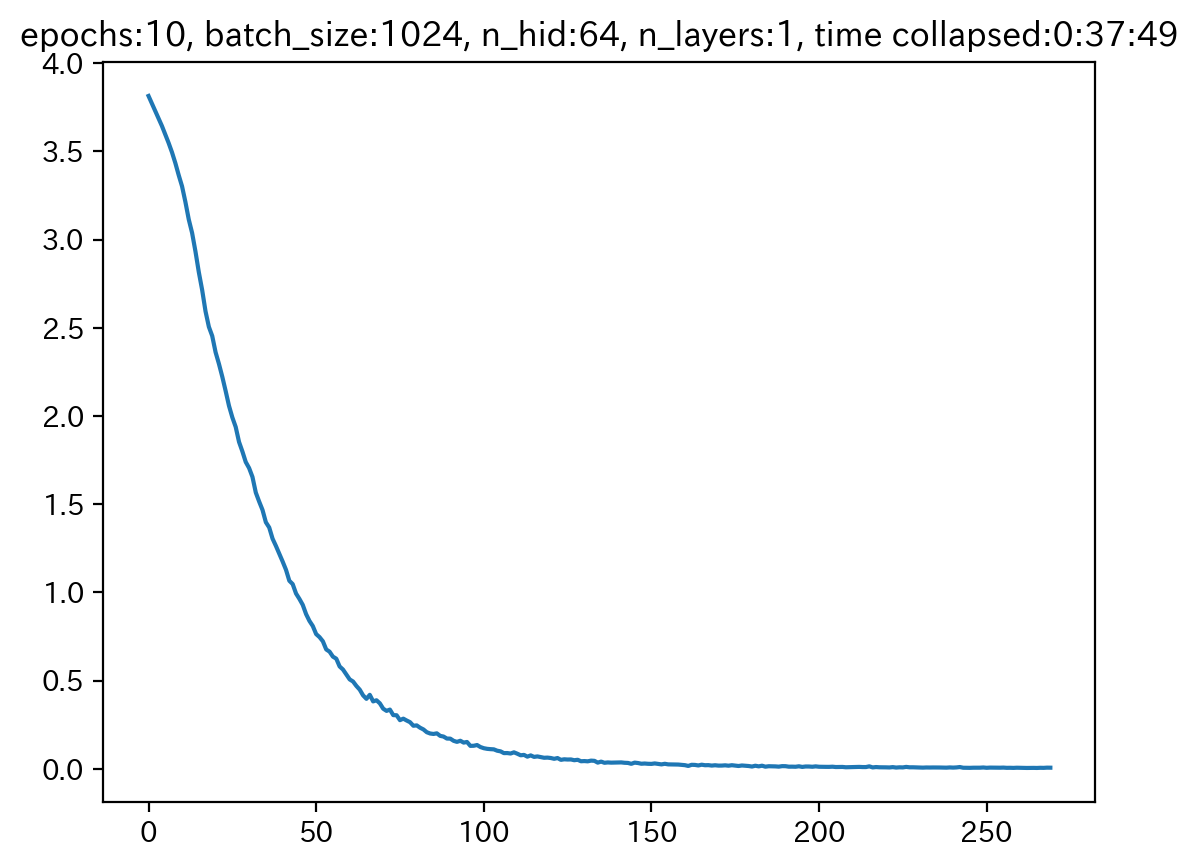

In [ ]:
from torch.nn.utils.rnn import pad_sequence

start_time = time.time()   # 開始時刻の保存

# ハイパーパラメータの設定
n_hid = 64
n_layers = 1
epochs = 10
bidirectional=True

# モデルの定義
model = EncDec_w_Att(enc_vocab_size=len(_psylex71_ds.phoneme),
                     dec_vocab_size=len(_psylex71_ds.phoneme),
                     n_layers=n_layers,
                     bidirectional=bidirectional,
                     n_hid=n_hid).to(device)

# データローダの定義
batch_size = 1024
dataloader = DataLoader(dataset=_psylex71_ds_s2p,
#dataloader = DataLoader(dataset=_psylex71_ds,
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=0,
                        collate_fn=_collate_fn)

# 最適化関数の定義
optimizer = optim.Adam(model.parameters(),lr=0.001)
# 損失関数
criterion = nn.CrossEntropyLoss(ignore_index=-1)

# 訓練ループ
model.train()
interval = int(_psylex71_ds.__len__()/batch_size) >> 2
losses = []
for epoch in range(epochs):
    i = 0
    for x, y in dataloader:
        enc_inp = pad_sequence(y, batch_first=True).to(device)
        #enc_inp = pad_sequence(y, batch_first=True).to(device)[:,:-1]
        #enc_inp = pad_sequence(y, batch_first=True).to(device)[:,1:]

        dec_inp = pad_sequence(y, batch_first=True).to(device)[:,:]
        #dec_inp = pad_sequence(y, batch_first=True).to(device)[:,:-1]
        #dec_inp = pad_sequence(y, batch_first=True).to(device)[:,1:]

        tch = pad_sequence(y, batch_first=True, padding_value=-1.0).to(device)
        #tch = tch[:,1:]

        out = model(enc_inp, dec_inp)
        loss = criterion(out[0], tch[0])
        for h in range(1,len(tch)):
            loss += criterion(out[h], tch[h])
        losses.append(loss.item()/len(x))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item()/len(x):.3f}')

end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

## 1.3 結果の検証

In [ ]:
isPrint = False
errors = []
model.eval()
for N in tqdm(range(_psylex71_ds.__len__())):
    x =_psylex71_ds.__getitem__(N)[1].to(device)

    enc_inp, dec_inp = x[1:].unsqueeze(0), x[:-1].unsqueeze(0)
    y = model(enc_inp, dec_inp).to('cpu')
    y_ids = np.argmax(y.squeeze(0).detach().numpy(), axis=1)[1:]
    y_phon = _psylex71_ds.phon_ids2phn(y_ids)
    grand_truth = _psylex71_ds.getitem(N)

    n_correct = np.array((y_ids == grand_truth[2]).sum())
    isOK = n_correct == len(grand_truth[2])

    if not isOK:
        errors.append((N,y_ids))
    if isPrint:
        color = 'grey' if isOK else 'red'
        print(colored((f'idx:{N:5d}',
                       f'出力:{y_phon}',
                       f'正解:{_psylex71_ds.phon_ids2phn(grand_truth[2])}',
                       f'単語:{grand_truth[0]}',
                      ), color, attrs=['bold']))
    #if color == 'red':
    #if N >= 39:
    #    break

cr = len(errors) / N
#cr = len(errors) / _psylex71_ds.__len__()
print(f'総エラー数:{len(errors)}',
      f'正解率:{(1.-cr)*100:.3f}%')

  0%|          | 0/26877 [00:00<?, ?it/s]

総エラー数:4358 正解率:83.785%


In [ ]:
errors = []
model.eval()
for N in range(_psylex71_ds.__len__()):
#for N in np.random.permutation(_psylex71_ds.__len__())[:100]:
    x, y = _psylex71_ds.__getitem__(N)

        enc_inp = pad_sequence(y, batch_first=True).to(device)[:,1:]
        #enc_inp = pad_sequence(x, batch_ffirst=True).to(device)
        dec_inp = pad_sequence(y, batch_first=True).to(device)[:,1:]
        tch = pad_sequence(y, batch_first=True, padding_value=-1.0).to(device)

    #enc_inp = torch.from_numpy(np.array(x)).to(device).unsqueeze(0)
    #dec_inp = pad_sequence(y, batch_first=True).to(device)[:,1:]
    #tch = pad_sequence(y, batch_first=True, padding_value=-1.0).to(device)
    #tch = tch[:,1:]
    #enc_inp.size()
    enc_emb = model.enc_transform_layer(enc_inp)
    hnx, cnx = enc_emb.clone(), enc_emb.clone()
    dec_inp = y
    dec_emb = model.decoder_emb(dec_inp)
    dec_out, (hny, cny) = model.decoder(dec_emb,(hnx, cnx))
    dec_out = model.out_layer(dec_out)
    y_ids = np.argmax(dec_out.detach().numpy(),axis=1)

    n_correct = np.array((y_ids[1:-1] == _psylex71_ds.getitem(N)[2]).sum())
    isOK = n_correct == len(_psylex71_ds.getitem(N)[2])
    color = 'grey' if isOK else 'red'

    if not isOK:
        errors.append((N,y_ids))
        print(colored((f'{N:05d}', #y_ids,
                       "".join(p for p in _psylex71_ds.phon_ids2phn(y_ids[1:-1]))),color,attrs=["bold"]), end=" ")
        print(_psylex71_ds.getitem(N))

cr = len(errors) / _psylex71_ds.__len__()
print(f'総エラー数:{len(errors)}',
      f'正解率:{(1.-cr)*100:.3f}')

# 2. 産出モデル 意味から音韻

## 2.1 モデルの定義

In [ ]:
# Define model
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EncDec_s2p(nn.Module):
    def __init__(self,
                 sem_dim:int,
                 dec_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 bidirectional:bool=False):
        super().__init__()

        # 単語の意味ベクトル a.k.a 埋め込み表現 を decoder の中間層に接続するための変換層
        # 別解としては，入力層に接続する方法があるが，それはまた別実装にする
        self.enc_transform_layer = nn.Linear(in_features=sem_dim,
                                             out_features=n_hid)
        self.decoder_emb = nn.Embedding(num_embeddings=dec_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)

        self.decoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        # 最終出力層
        self.out_layer = nn.Linear(n_hid, dec_vocab_size)

    def forward(self, enc_inp, dec_inp):
        enc_emb = self.enc_transform_layer(enc_inp)
        hnx, cnx = enc_emb.clone(), enc_emb.clone()
        dec_emb = self.decoder_emb(dec_inp)
        dec_out, (hny, cny) = self.decoder(dec_emb,(hnx, cnx))
        return self.out_layer(dec_out)

n_hid = 64
n_layers = 1
bidirectional=False
# 直下行で，enc_vocab_size と dec_vocab_size を phoneme にしているので，音韻複勝課題に相当する
enc_dec = EncDec_s2p(sem_dim=_psylex71_ds.w2v.vector_size,
                     dec_vocab_size=len(_psylex71_ds.phoneme),
                     n_layers=n_layers,
                     bidirectional=bidirectional,
                     n_hid=n_hid).to(device)
enc_dec.eval()

## 2.2 訓練の実施

In [ ]:
start_time = time.time()
n_hid = 64
n_layers = 1
epochs = 10
bidirectional=False
model = EncDec_s2p(sem_dim=_psylex71_ds.w2v.vector_size,
                   dec_vocab_size=len(_psylex71_ds.phoneme),
                   n_layers=n_layers,
                   bidirectional=bidirectional,
                   n_hid=n_hid).to(device)

optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=-1)

model.train()
interval = int(_psylex71_ds.__len__()/batch_size) >> 2
losses = []
for epoch in range(epochs):
    i = 0
    for x, y in dataloader:
        enc_inp = torch.from_numpy(np.array(x)).to(device).unsqueeze(0)
        dec_inp = pad_sequence(y, batch_first=True).to(device)
        tch = pad_sequence(y, batch_first=True, padding_value=-1.0).to(device)
        out = model(enc_inp, dec_inp)
        loss = criterion(out[0], tch[0])
        for h in range(1,len(tch)):
            loss += criterion(out[h], tch[h])
        losses.append(loss.item()/len(x))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item()/len(x):.3f}')

end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

## 2.3 学習結果の評価

In [ ]:
model.eval()
isPrint = False
errors = []
for N in tqdm(range(_psylex71_ds.__len__())):
#for N in np.random.permutation(_psylex71_ds.__len__())[:100]:
    x, y = _psylex71_ds.__getitem__(N)
    enc_inp = torch.from_numpy(np.array(x)).to(device).unsqueeze(0)
    enc_emb = model.enc_transform_layer(enc_inp)
    hnx, cnx = enc_emb.clone(), enc_emb.clone()
    dec_inp = y
    dec_emb = model.decoder_emb(dec_inp)
    dec_out, (hny, cny) = model.decoder(dec_emb,(hnx, cnx))
    dec_out = model.out_layer(dec_out)
    y_ids = np.argmax(dec_out.detach().numpy(),axis=1)

    n_correct = np.array((y_ids[1:-1] == _psylex71_ds.getitem(N)[2]).sum())
    isOK = n_correct == len(_psylex71_ds.getitem(N)[2])
    color = 'grey' if isOK else 'red'

    if not isOK:
        errors.append((N,y_ids))
    if isPrint:
        print(colored((f'{N:05d}', #y_ids,
                       "".join(p for p in _psylex71_ds.phon_ids2phn(y_ids[1:-1]))),color,attrs=["bold"]), end=" ")
        print(_psylex71_ds.getitem(N))

cr = len(errors) / _psylex71_ds.__len__()
print(f'総エラー数:{len(errors)}',
      f'正解率:{(1.-cr)*100:.3f}')


# 3 理解モデル 音韻から意味

## 3.1 モデルの定義

In [ ]:
torch.tensor

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EncDec_p2s(nn.Module):
    def __init__(self,
                 sem_dim:int,
                 enc_vocab_size:int,
                 n_hid:int,
                 n_layers:int=2,
                 bidirectional:bool=False):
        super().__init__()
        self.encoder_emb = nn.Embedding(num_embeddings=enc_vocab_size,
                                        embedding_dim=n_hid,
                                        padding_idx=0)

        self.encoder = nn.LSTM(input_size=n_hid,
                               hidden_size=n_hid,
                               num_layers=n_layers,
                               batch_first=True,
                               bidirectional=bidirectional)

        bi_fact = 2 if bidirectional else 1
        self.out_layer = nn.Linear(in_features=n_hid * bi_fact,
                                   out_features=sem_dim)

    def forward(self, enc_inp):
        enc_emb = self.encoder_emb(enc_inp)
        enc_out, (hid, cel) = self.encoder(enc_emb)
        _sem = self.out_layer(hid)
        return _sem, enc_out


n_hid = 64
n_layers = 1
bidirectional=False
model = EncDec_p2s(sem_dim=_psylex71_ds.w2v.vector_size,
                   enc_vocab_size=len(_psylex71_ds.phoneme),
                   n_hid=n_hid,
                   n_layers=n_layers,
                   bidirectional=bidirectional)
model.eval()

## 3.2 訓練の実施

In [ ]:
start_time = time.time()
n_hid = 64
n_layers = 1
epochs = 50
bidirectional=False
model = EncDec_p2s(sem_dim=_psylex71_ds.w2v.vector_size,
                   enc_vocab_size=len(_psylex71_ds.phoneme),
                   n_layers=n_layers,
                   bidirectional=bidirectional,
                   n_hid=n_hid).to(device)

optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion_dec = nn.MSELoss()
criterion_enc = nn.CrossEntropyLoss(ignore_index=-1)

model.train()
interval = int(_psylex71_ds.__len__()/batch_size) >> 2
losses = []
for epoch in range(epochs):
    i = 0
    for x, y in dataloader:
        enc_inp = pad_sequence(y, batch_first=True).to(device)
        tch = torch.tensor([_x.detach().numpy() for _x in x]).to(device)

        out, enc_out = model(enc_inp)
        loss = criterion_dec(out, tch)

        for _x, _y in zip(enc_out[:,:-1], enc_inp[:,1:]):
            loss += criterion_enc(_x, _y)
        losses.append(loss.item()/len(x))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item()/len(x):.3f}')

end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()

#outfile = "attnmt2-" + str(epoch) + ".model"
#torch.save(net.state_dict(),outfile)

## 3.3 学結果の評価

In [ ]:
model.eval()

In [ ]:
model.eval()
isPrint = False
errors = []
#for N in tqdm(range(_psylex71_ds.__len__())):
for N in np.random.permutation(_psylex71_ds.__len__())[:2]:
    x, y = _psylex71_ds.__getitem__(N)
    enc_inp = y.to(device).unsqueeze(0)
    #tch = x.to(device)

    out, enc_out = model(enc_inp)
    # print(f'type(out):{type(out)}',
    #       f'len(out):{len(out)}'
    #       f'out.size():{out.size()}'
    #      )
    out = out.detach().squeeze().numpy()
    print(N)
    print(_psylex71_ds.getitem(N)[0])
    print(_psylex71_ds.w2v.similar_by_vector(out,topn=3))
    # print(f'type(out):{type(out)}',
    #       f'len(out):{len(out)}'
    #       f'out.shape:{out.shape}'
    #      )
    sys.exit()


    n_correct = np.array((y_ids[1:-1] == _psylex71_ds.getitem(N)[2]).sum())
    isOK = n_correct == len(_psylex71_ds.getitem(N)[2])
    color = 'grey' if isOK else 'red'

    if not isOK:
        errors.append((N,y_ids))
    if isPrint:
        print(colored((f'{N:05d}', #y_ids,
                       "".join(p for p in _psylex71_ds.phon_ids2phn(y_ids[1:-1]))),color,attrs=["bold"]), end=" ")
        print(_psylex71_ds.getitem(N))

cr = len(errors) / _psylex71_ds.__len__()
print(f'総エラー数:{len(errors)}',
      f'正解率:{(1.-cr)*100:.3f}')


In [ ]:
help(_psylex71_ds.w2v.similar_by_vector)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EncDec_s2s(nn.Module):
    def __init__(self,
                 sem_dim:int,
                 n_hid:int):
        super().__init__()
        self.hidden_layer = nn.Linear(in_features=sem_dim,
                                      out_features=n_hid)
        self.out_layer = nn.Linear(in_features=n_hid,
                                   out_features=sem_dim)

    def forward(self, enc_inp):
        hid = self.hidden_layer(enc_inp)
        out = self.out_layer(hid)
        return out


n_hid = 128
#model = EncDec_s2s(sem_dim=_psylex71_ds.w2v.vector_size,
#                   n_hid=n_hid)

model = nn.Sequential(
    nn.Linear(_psylex71_ds.w2v.vector_size, n_hid),
    nn.ReLU(),
    nn.Linear(n_hid, n_hid),
    nn.ReLU(),
    nn.Linear(n_hid, _psylex71_ds.w2v.vector_size),
    nn.Tanh()
)


start_time = time.time()
epochs = 20
optimizer = optim.Adam(model.parameters(),lr=0.001)
criterion = nn.MSELoss()

model.train()
interval = int(_psylex71_ds.__len__()/batch_size) >> 2
losses = []
for epoch in range(epochs):
    i = 0
    for x, y in dataloader:
        tch = torch.tensor([_x.detach().numpy() for _x in x]).to(device)

        out = model(tch)
        loss = criterion_dec(out, tch)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1
        if (i % interval) == 0:
            print(f'epoch:{epoch:2d}, batch:{i:2d}, loss:{loss.item():.3f}')

end_time = time.time()
total_time = end_time - start_time
total_time_str = str(datetime.timedelta(seconds=int(total_time)))
print(f'Training time {total_time_str}')

plt.plot(losses)
plt.title(f'epochs:{epochs}, batch_size:{batch_size}, n_hid:{n_hid}, n_layers:{n_layers}, time collapsed:{total_time_str}')
plt.show()


# 4) 書記から意味
# 5) 意味から書記
# 6) 書記から意味を解して音韻

# 7) 書記から意味を介さず音韻
# 8) 6 と 7 の比較

In [ ]:
#help(RAM.chars_joyo)
j = RAM.chars_joyo()
#print(dir(j))
ch_list = ['<PAD>', '<SOW>', '<EOW>', '<UNK>'] + j.char_list
not_chlist = []
for N in range(_psylex71_ds.__len__()):
    wrd = _psylex71_ds.getitem(N)[0]
    for ch in wrd:
        if (ch not in ch_list) and (ch not in not_chlist):
            not_chlist.append(ch)
print(len(not_chlist))

In [ ]:
print(sorted(not_chlist))

In [ ]:
#help(RAM.chars_joyo)
print(len(grapheme))
#print(grapheme)
#print(chars_list + not_chars_list)